## Lab 4: Introduction to Reinforcement Leaerning

In this lab we will get a small taste of the power Reinforcement Learning (RL) has to offer when it comes to robotics and control. Your task will be to use the [gym](https://gym.openai.com/docs/) library to simulate a small MDP environment, and use tabular Q-learning to solve it. 

Given the interdisciplinary nature of RL, the breadth of the topic can easily fill multiple courses. Here, you will be introduced to the math you need to succesfully implement Q-learning, but the reasoning behind all the steps is not explained. I recommend starting at this [lecture](https://www.youtube.com/watch?v=E3f2Camj0Is&list=PLoROMvodv4rOSOPzutgyCTapiGlY2Nd8u&index=2) for those interested. Note that 
it takes three lectures (2-4) to arrive at the Q-learning formulation.




## Lab Overview
### I. gym
### II. Markov Decision Processes
### III. Q-learning

### You are responsible for completing the tasks explained in:
- **Cells 7-8**: Your tabular Q-learning implementation.
- **Cells 11-12**: A plot of your training statistics.


### I. gym

The [gym](https://gym.openai.com/docs/) library is a benchmark suite for RL provided by OpenAI. It is widely used in research due to its easy integration with python.

You can install it below as we did for scipy in the last lab, or use the new yml file provided. 

In [1]:
pip install gym

In [2]:
import gym
import numpy as np 


There are a ton of environments to choose from with gym, they can all be accessed using their associated name. 

In [3]:
env = gym.make("Taxi-v3").env

Once you've made the environemnt, you can directly interact with the env object created.

Here we will look at the taxi environment, where the goal of the agent/robot/taxi is to pick up a passenger from one of  four possible locations, and drop them off at another. Since the environment is small and does not relocate the obstacles it is easy to solve methodically, but we will see how a general algorithm can be used to find the ideal policy.  

We can take a look at what's going on up close:

In [4]:
env.render() 

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



[Taxi-v3](https://gym.openai.com/envs/Taxi-v3/)

A thorough explanation directly from the [source](https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py):

#
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich

    Description:
    There are four designated locations in the grid world indicated 
    by R(ed), G(reen), Y(ellow), and B(lue). 
    When the episode starts, the taxi starts off at a random square 
    and the passenger is at a random location. 
    The taxi drives to the passenger's location, 
    picks up the passenger, drives to the passenger's destination 
    (another one of the four specified locations), and then drops off the passenger. 
    Once the passenger is dropped off, the episode ends.
    Observations:
    There are 500 discrete states since there are 25 taxi positions, 
    5 possible locations of the passenger, and 4 destination locations. 

    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi

    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)

    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
#

So how do we interact with the environment?

Essentially you only need two methods: a way to reset the environment once the passenger has been dropped off, and a way to take a specific action. 

We first take a look at the env.reset() method. When you reset a gym environment, it returns the initial state of the env. Technically the state should be a 4-dim vector: (taxi_row, taxi_col, passenger_location, destination), but since there are only 500 possible states the vector is encoded to an integer value. If you want to make sense of this value in its original representation you can use the provided env.decode() method.  


In [5]:
output = env.reset()
print(list(env.decode(output)))
env.render()


[2, 1, 3, 1]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
print(output)

233


Okay that was the reset, now the second ingredient we need is a way to control the env. We can do this with env.step(), where the input should be an integer b/w 0 and 5 as described above. Once we take our desired action with env.step(), it returns 4 items: the next state,the reward recieved for taking our action, a boolean that checks if we are done, and information regarding the states visited (we dont need this last part). 

In [7]:
state, rew, done, _ = env.step(4)
env.render()
print('state: \t', list(env.decode(state)))
print('rew: \t', rew)
print('done: \t', done)


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
state: 	 [2, 1, 3, 1]
rew: 	 -10
done: 	 False


### II. Markov Decision Processes
Markov Chains (MC) are powerful tools for modeling the dynamics of systems. What if we wanted to use an MC to model a certain game, evaluating different policies to compare them? We can just use MCs, but since we want a good metric to evaluate these policies, we need to consider taking different actions and recieving a reward signal for feedback. At some state $s_t$ in the MC, we can take an action $a_t$, and observe not only the next state $s_{t+1}$, but also the reward $r_t$ associated with that transition. This is how Markov Decision Processes (MDP) are formed i.e., they combine elements of control with the Markovian model.  

MDPs rely on the Markov Assumption:
$$
P(s_{t+1}|s_t,a_t)=P(s_{t+1}|h_t,a_t),
$$
where $h_t$ is the history of all states up to step $t$. Essentially, this says that we only need to know the current state and the action to predict the outcome. With this assumption, we can formulate an MDP $\mathcal{M}:\{\mathcal{S},\mathcal{A},P,R\}$ as a collection of a set of states, a set of actions, a probability transition function and a reward transition function respectively. 

We also need a way to express the policy:  
$$\pi: \mathcal{S}\mapsto\mathcal{A},$$
where in the determenistic case $\pi(s)=a$. Otherwise $\pi(a|s) = Pr.(a_t=a|s_t=s)$

At every state $s_t$, we receive a reward $r_t=R(s,a)$ for taking action $a_t$. By rolling out a certain policy $\pi$ in our MDP, we can collect what we call the return at step $t$:
$$
G_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \ldots.
$$
You can think of this as the total payout we will get if we run polciy $\pi$ in our given MDP, where $\gamma$ is a the discount factor we give towards rewards we receive in the future. We set $\gamma<1$ in order to give higher weight to rewards that come sooner, but also this makes sure that our return $G_t$ is finite even if our policy runs for an infinite time. This way we do not have to worry about the horizon of our MDP. 





#### Value and Q Function.
A major component in reinforcement learning is keeping track of the expected return a certain policy will provide in an environment. This is defined as the value function:
$$
V^{\pi}(s_t=s)=E_{\pi}[G_t|s_t=s].
$$
If we knew the value function for any policy $\pi$, we can easily compare the quality of different polcieis. But we can go one step further with our evaluation. Say at a given state $s_t$ we wanted to evaluate our policy $\pi$, but only after taking a certain action $a_t$, and then continuing with our policy $\pi$. This is defined as the Q-function: 
$$
Q^{\pi}(s_t=s,a_t=a) = R(s,a) + \gamma\sum_{s'\in\mathcal{S}}P(s'|s,a)V^{\pi}(s')
$$
The methodology here is that we can now evaluate our off policy decision to take action $a$. Since we know how we can estimate the value function, computing the Q-values allows us to take $\max_a Q^\pi(s,a)$ instead of following the policy, since this is gauranteed to be atleast as good as following $\pi$. 

### III. Tabular Q-Learning
In Q-Learning we measure the Temporal Difference between **target** and **current estimate** of the Q-function. 
$$
\begin{align}
\textrm{target: }&\qquad r_t + \gamma\max_{a'}Q(s_{t+1},a')\\
\textrm{estimate: }&\qquad Q(s_t,a_t)
\end{align}
$$
Their difference measures the error between what the environment is telling us, and our current estimate. We can use this error to update our current estimate, which formulates the Q-learning algorithm:
$$
Q(s_t,a_t) := Q(s_t,a_t)+\alpha\Big(r_t+\gamma\max_{a'}Q(s_{t+1},a')-Q(s_t,a_t)\Big).
$$
Now we just need a way to evaluate the policy, for which we use the epsilon-greedy approach: 
$$
\pi(a|s)=
\begin{cases}
\textrm{arg}\max_a Q^\pi(s,a)\qquad \textrm{w. prob } 1-\epsilon,\\
\textrm{take a random action}\qquad \textrm{w. prob } \epsilon.
\end{cases}
$$
Note how $\epsilon$ controls how much we $\textit{explore}$ the environment versus how much we $\textit{exploit}$ our policy. A lot of RL is posed as a battle between exploration and exploitation, hence $\epsilon$ is an important parameter. Typically we want to decrease the amount we explore as our policy gets better, and we do this by adapting some sort of **decay** to $\epsilon$. In addition, since $\alpha$ controls the speed at which we update our policy, you can consider adapting some decay as well. 

I will leave this element for you to experiment with, as it serves as an interesting challenge to try and find the correct parameters and fine tune. As a reference, you should be able to find the policy within 20,000 episodes (where episodes end when the taxi drops off the passenger.) In fact, even 5,000 is enough but you will see slight improvement following. 



#### Your task.

The actual algorithm can be written within one cell, or broken up into smaller components, it is your choice. There are only two things I require:

(1) **Represent your Q-table as an np.array of size (500,6)**, hence 500 states and 6 actions. This will let you use my policy evaluation function that follows to check if you found the solution. You might want to take a look at that function first if you have any confusion about how to interact with the gym env. 

(2) **Collect reward statistic of your policy over the 20,000 episodes, and plot it yourself.** You will  probably want this statistic for yourself anyway, but the plotting component is added so that we can better visualize our data. Typically we consider the episodic reward collected over one rollout, but note that using this directly will give youa noisy result. I leave the figure making up to you this time, feel free to use the templates or anything else that you like! 

Task (1):

Your Q-learning algorithm goes below. 

### Function for selecting action

In [8]:
# used to select random action
from numpy.random import default_rng
rng = default_rng(seed=42)

# this function chooses the next action to take
# which requires the current state, the Q table, and prob of random action
def choose_action(curr_state, Q_table, eps):
    # possible actions
    actions = Q_table[curr_state,:]

    # case 1: choose action with largest Q value for current state
    if rng.random() > eps:
        act = np.argmax(actions)
        return act
    # case 2: choose a random action from 0-5
    else:
        act = rng.integers(6)
        return act

### Driver Code

In [9]:
# state action table
Q_table = np.random.randn(500,6)

# define epsilon and alpha
eps = 0.2 # prob of random action
alpha = 0.3 # learning rate

# reset the state
state = env.reset()

# store rewards for all episodes, store number of iterations per episode
episodes = 20000
rewards = np.zeros(episodes)
episode_length = np.zeros(episodes)

# complete 20000 episodes
for i in range(episodes):
    # reset at start of episode
    state = env.reset()
    
    # choose an action based on the current state
    action = choose_action(state,Q_table,eps)

    # take the action and collect reward
    new_state, rew, done, _ = env.step(action)
    rewards[i] = rew

    # compute the temporal difference
    td = rew + np.max(Q_table[new_state,:]) - Q_table[state,action]

    # update the last state's Q value for that action
    Q_table[state,action] += alpha*td

    # save the current state
    state = new_state

    # keep taking actions and updating the table until the episode ends
    while done == False:
        # choose an action based on the current state
        action = choose_action(state,Q_table,eps)

        # take the action and collect reward
        new_state, rew, done, _ = env.step(action)
        rewards[i] += rew

        # compute the temporal difference
        td = rew + np.max(Q_table[new_state,:]) - Q_table[state,action]

        # update the last state's Q value for that action
        Q_table[state,action] += alpha*td

        # update the state variable
        state = new_state

        # increment the episode length
        episode_length[i] += 1

In [10]:
def eval_policy(env, Q_table):
    '''
    Evaluates the environment using the given policy 
    Inputs:
        env - gym env object
        Q   - policy, we will use arg max Q. 

    Note that I use count to make sure we exit the 
    rendering if our policy takes longer than 50 steps. 
    This way we can observe arbitrary Q tables, feel
    free to tune this value.  
    '''
    state = env.reset()
    env.render()
    done = False
    count = 50
    while not done:
        count-=1
        if count <= 0:
            return

        act = np.argmax(Q_table[state])
        state, rew, done, _ = env.step(act)
        env.render()

        print('state: \t', list(env.decode(state)))
        print('rew: \t', rew)
        print('done: \t', done)
    # return


We can now evaluate our policy using the Q table. 


In [11]:
eval_policy(env, Q_table)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
state: 	 [2, 3, 2, 3]
rew: 	 -1
done: 	 False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
state: 	 [2, 2, 2, 3]
rew: 	 -1
done: 	 False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
state: 	 [2, 1, 2, 3]
rew: 	 -1
done: 	 False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
state: 	 [2, 0, 2, 3]
rew: 	 -1
done: 	 False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
state: 	 [3, 0, 2, 3]
rew: 	 -1
done: 	 False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
state: 	 [4, 0, 2, 3]
rew: 	 -1
done: 	 False
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+-----

Feel free to use this template for your second task.

In [12]:
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
# colors used
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
FIG_WIDTH = 4
FIG_HEIGHT = 3

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.serif": ["Palatino"],
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 2
})

Task (2):

Plot your data below.

([<matplotlib.axis.XTick at 0x1b36fee1340>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

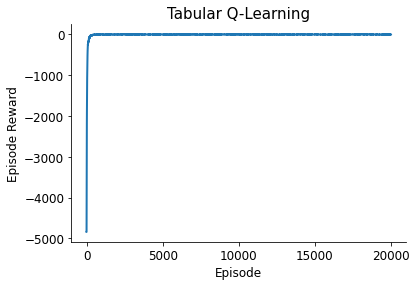

In [13]:
# generate an exponentially smoothed version of the plot
smoothed = np.zeros(episodes)
smoothed[0] = rewards[0]
alpha = 0.05
for i,reward in enumerate(rewards):
    if i == episodes-1:
        break
    smoothed[i+1] = alpha*reward+(1-alpha)*smoothed[i]
plt.plot(smoothed)
plt.title("Tabular Q-Learning")
plt.ylabel("Episode Reward")
plt.xlabel("Episode")
plt.xticks([0,5000,10000,15000,20000])